<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/classify_Gaussian_blurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Gaussian:
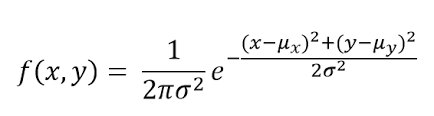

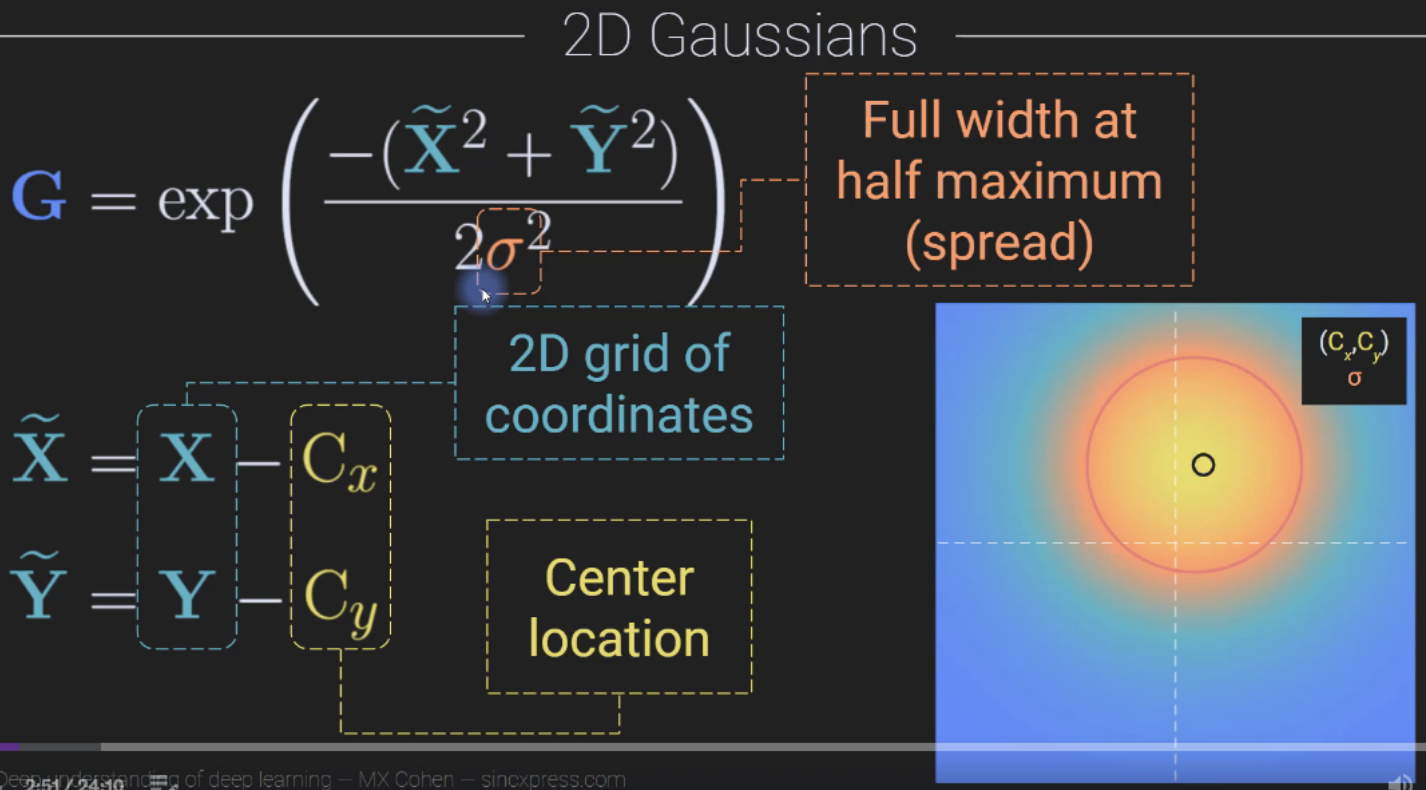

# Layers:
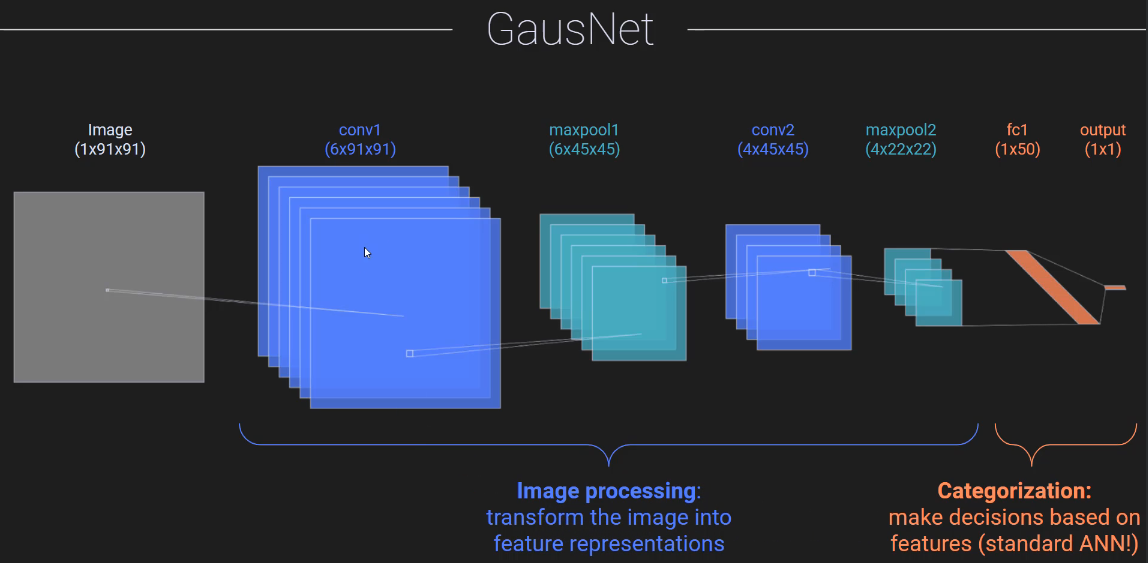

In [13]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [14]:
# create Gaussian blurs with different widths:

nPerClass = 1000 # 1000 imgs for each category
imgSize   = 91   # 91x91 pixels

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.]
X,Y = np.meshgrid(x,x) # create a coordinate grid from the arrays `x` and `x`

# two different widths (arbitrary units) -> sigma:
widths = [1.8, 2.4]

# initialize images and labels:
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
  # generates an array (random centers) with 2 random numbers, sampled from a normal distribution with a mean of 0 and a standard deviation of 2
  ro = 2*np.random.randn(2) # ro: random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) ) # `i%2` returns the remainder after division (alternate between 0 and 1) -> choose 1.8 and 2.4 alternatively

  # add noise: 2D array filled with random numbers sampled from a standard normal distribution with a mean of 0 and standard deviation of 1
  G  = G + np.random.randn(imgSize,imgSize)/5

  # (91, 91) np array -> (1, 91, 91) torch tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

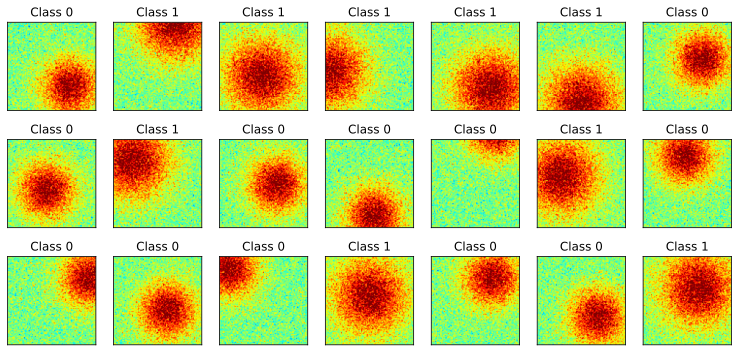

In [15]:
# visualize some images:

fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [16]:
# use scikitlearn to split the data (torch tensor)
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# torch tensor -> torch Dataset obj
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch DataLoader obj
batchsize    = 32 # 32 samples in each minibatch
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [17]:
# check size (imgs x channels x W x H
print( train_loader.dataset.tensors[0].shape ) # images
print( train_loader.dataset.tensors[1].shape ) # labels

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [18]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45

          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22

          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,1),             # output size: 1
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss() # already incorporates log softmax

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [19]:
# test the model with one batch:

net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader)) # extract one batch, 32 samples in the minibatch
yHat = net(X)

# check size of output
print(yHat.shape) # [32, 1]

# # now let's compute the loss
loss = lossfun(yHat,y)
print('loss:', loss)

torch.Size([32, 1])
loss: tensor(0.6826, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [20]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [21]:
# a function to train the model:

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    batchLoss = []
    batchAcc  = []

    # loop over training data batches
    for X,y in train_loader:
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [22]:
# train the model:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

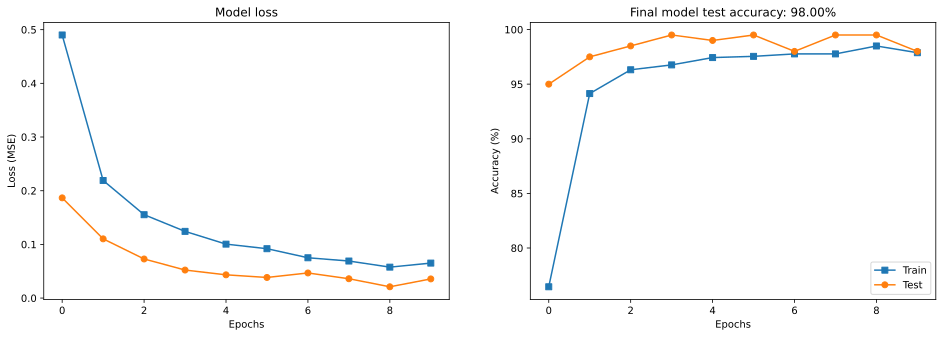

In [23]:
# show the results:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

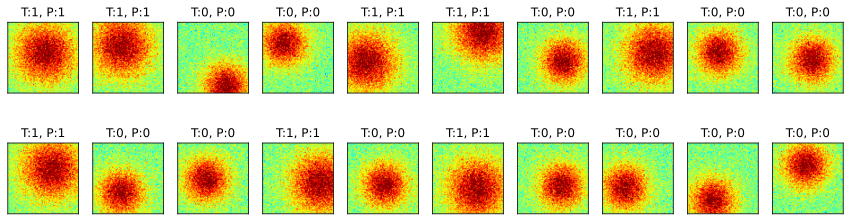

In [24]:
# show how accurate the classifications are:

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [26]:
# look at the filters:
print(net, "\n")

# access specific layers through indexing & get weight filters (ref to the print-out below):
layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
) 

torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


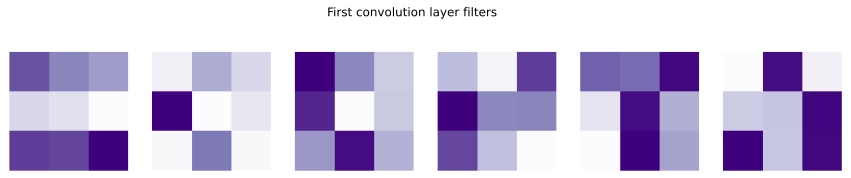

In [27]:
# 1st conv layer:

fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

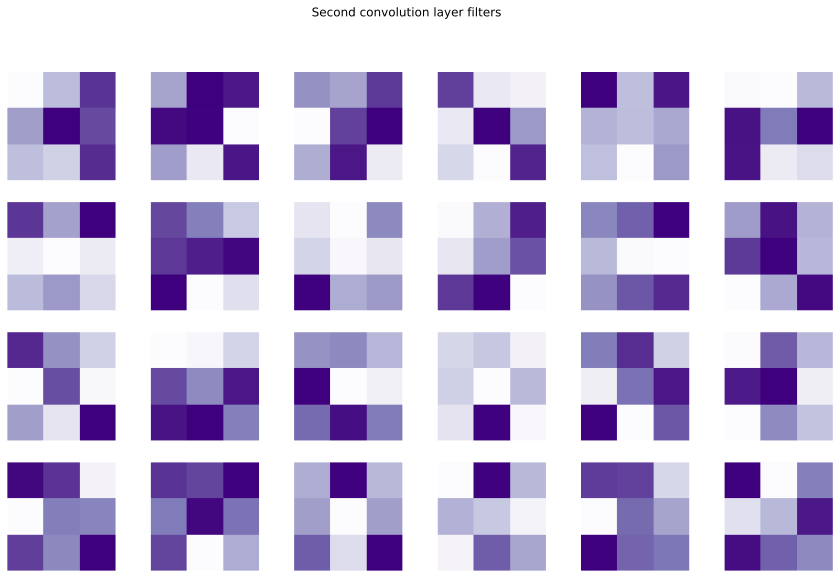

In [28]:
# 2nd conv layer:

fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

Interpretations:

---
- The weights (convolution kernels) change during learning, but are fixed after learning.
- Kernels are independent of the data.
- The feature maps are not learned. Instead they are representations of the data.
- Feature maps can look completely different for different images, although the weights (convolution kernels) are identical.